In [1]:
library(tidyverse)
library(lubridate)

# Read single CSV (adjust path to your file)
bike_data <- read_csv("JC-201902-citibike-tripdata.csv", col_types = cols(starttime = col_datetime(format = "%Y-%m-%d %H:%M:%OS"),
                                                                          stoptime = col_datetime(format = "%Y-%m-%d %H:%M:%OS")))

# For merging multiple files (Feb-Jun 2019):
files <- list.files(pattern = "JC-20190[2-6]-citibike-tripdata\\.csv", full.names = TRUE)
bike_data <- map_dfr(files, read_csv)  # Combine all into one tibble

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 18565 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (3): start station name, end station name, usertype
dbl  (10): tripduration, start station id, start station latitude, start sta...
dttm  (2): starttime, stoptime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 23606 Columns: 15
── Colum

In [2]:
# Check missing values
colSums(is.na(bike_data))

# Remove rows with missing data
bike_data_clean <- bike_data %>% drop_na()

tripduration               starttime                stoptime 
                      0                       0                       0 
       start station id      start station name  start station latitude 
                      0                       0                       0 
start station longitude          end station id        end station name 
                      0                       0                       0 
   end station latitude   end station longitude                  bikeid 
                      0                       0                       0 
               usertype              birth year                  gender 
                      0                       0                       0

In [3]:
bike_data_clean <- bike_data_clean %>% 
  mutate(duration_min = tripduration / 60)

mean_duration <- mean(bike_data_clean$duration_min)
median_duration <- median(bike_data_clean$duration_min)
print(mean_duration)
print(median_duration)

[1] 12.81071
[1] 5.683333


In [4]:
min_duration <- min(bike_data_clean$duration_min)
max_duration <- max(bike_data_clean$duration_min)
print(max_duration)
# Check plausibility: e.g., max_duration = 1497 minutes (~24.9 hours) may indicate outliers.

[1] 28817


In [5]:
bike_skimmed <- bike_data_clean %>% filter(duration_min <= 180)
skimmed_count <- nrow(bike_data_clean) - nrow(bike_skimmed)

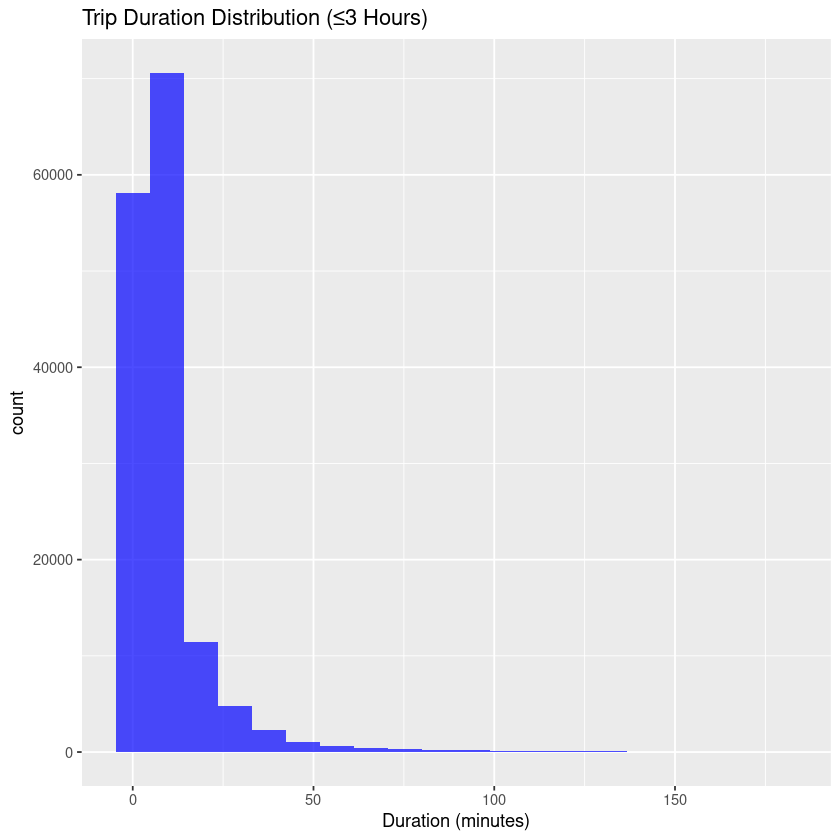

In [6]:
ggplot(bike_skimmed, aes(x = duration_min)) +
  geom_histogram(bins = 20, fill = "blue", alpha = 0.7) +
  labs(title = "Trip Duration Distribution (≤3 Hours)", x = "Duration (minutes)")

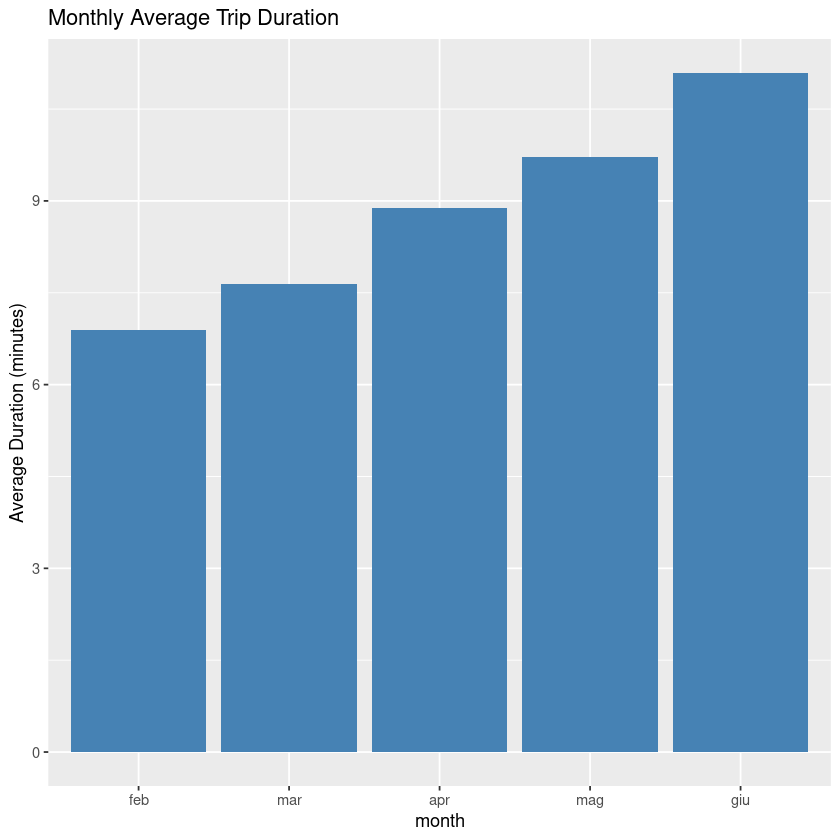

In [7]:
bike_skimmed %>%
  mutate(month = month(starttime, label = TRUE)) %>%
  group_by(month) %>%
  summarise(avg_duration = mean(duration_min)) %>%
  ggplot(aes(x = month, y = avg_duration)) +
  geom_col(fill = "steelblue") +
  labs(title = "Monthly Average Trip Duration", y = "Average Duration (minutes)")

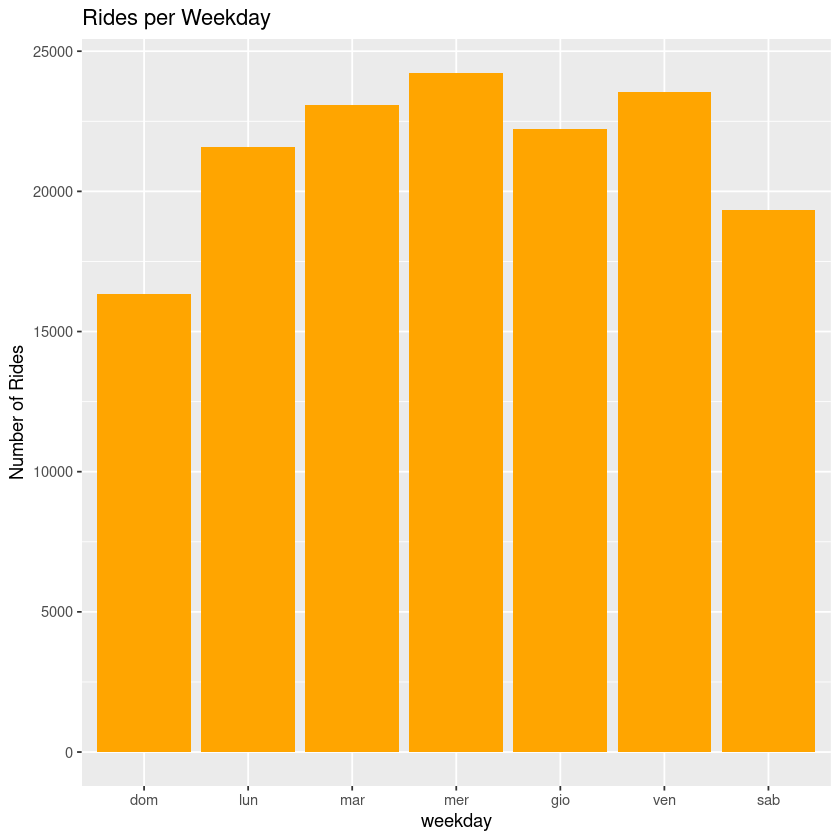

In [8]:
bike_skimmed %>% 
  mutate(weekday = wday(starttime, label = TRUE)) %>% 
  count(weekday) %>% 
  ggplot(aes(x = weekday, y = n)) +
  geom_col(fill = "orange") +
  labs(title = "Rides per Weekday", y = "Number of Rides")

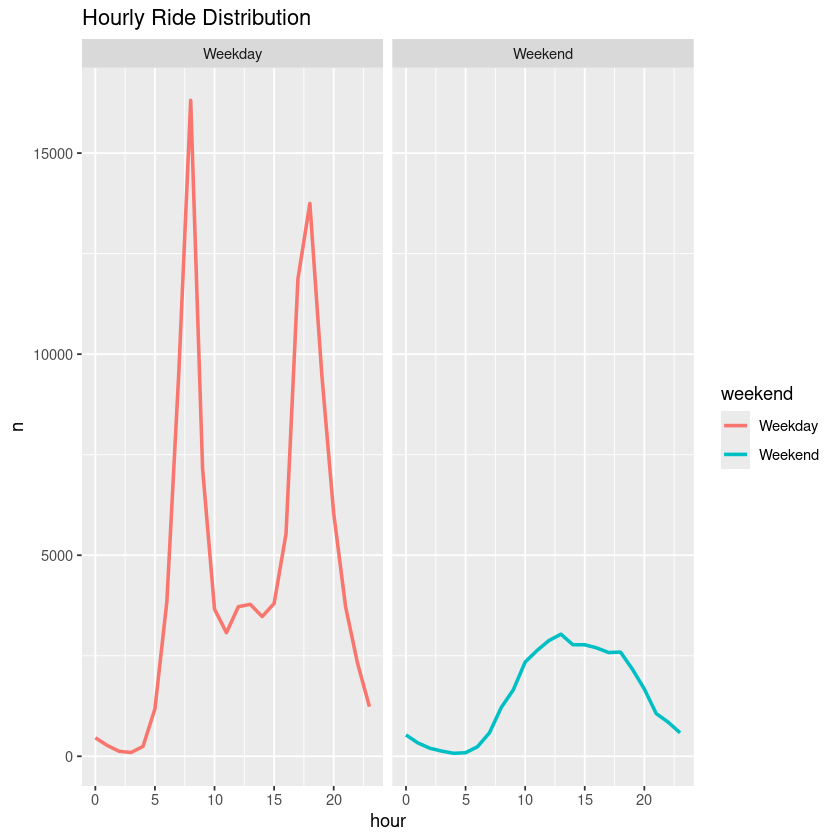

In [9]:
bike_skimmed %>% 
  mutate(
    weekend = ifelse(wday(starttime) %in% c(1, 7), "Weekend", "Weekday"),
    hour = hour(starttime)
  ) %>% 
  count(weekend, hour) %>% 
  ggplot(aes(x = hour, y = n, color = weekend)) +
  geom_line(linewidth = 1) +
  facet_wrap(~weekend) +
  labs(title = "Hourly Ride Distribution")

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


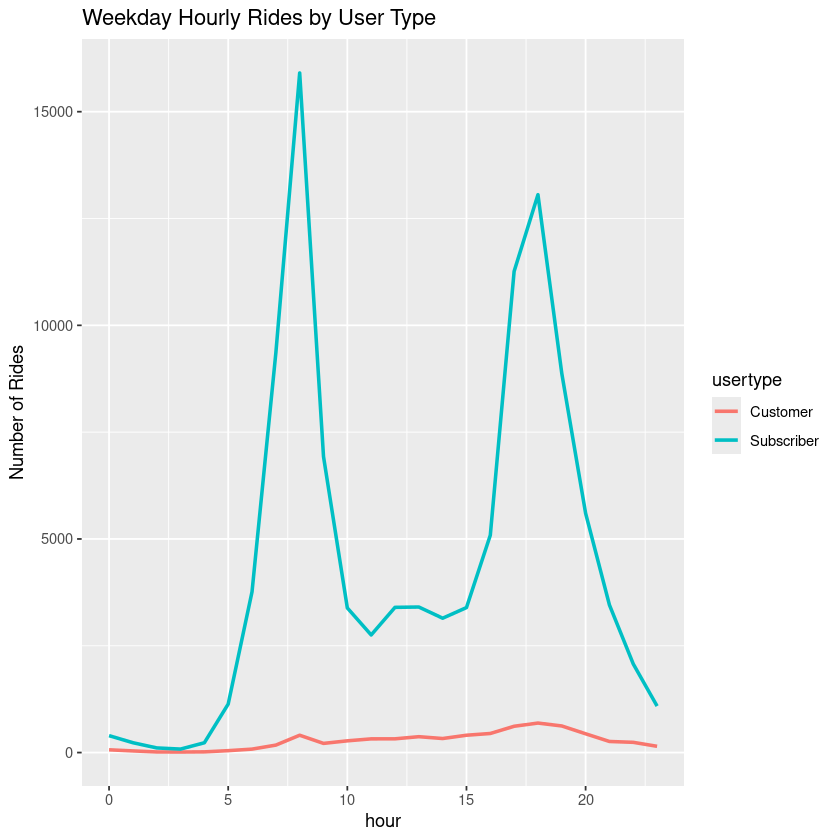

In [10]:
bike_skimmed %>% 
  filter(!wday(starttime) %in% c(1, 7)) %>% 
  mutate(hour = hour(starttime)) %>% 
  count(usertype, hour) %>% 
  ggplot(aes(x = hour, y = n, color = usertype)) +
  geom_line(size = 1) +
  labs(title = "Weekday Hourly Rides by User Type", y = "Number of Rides")

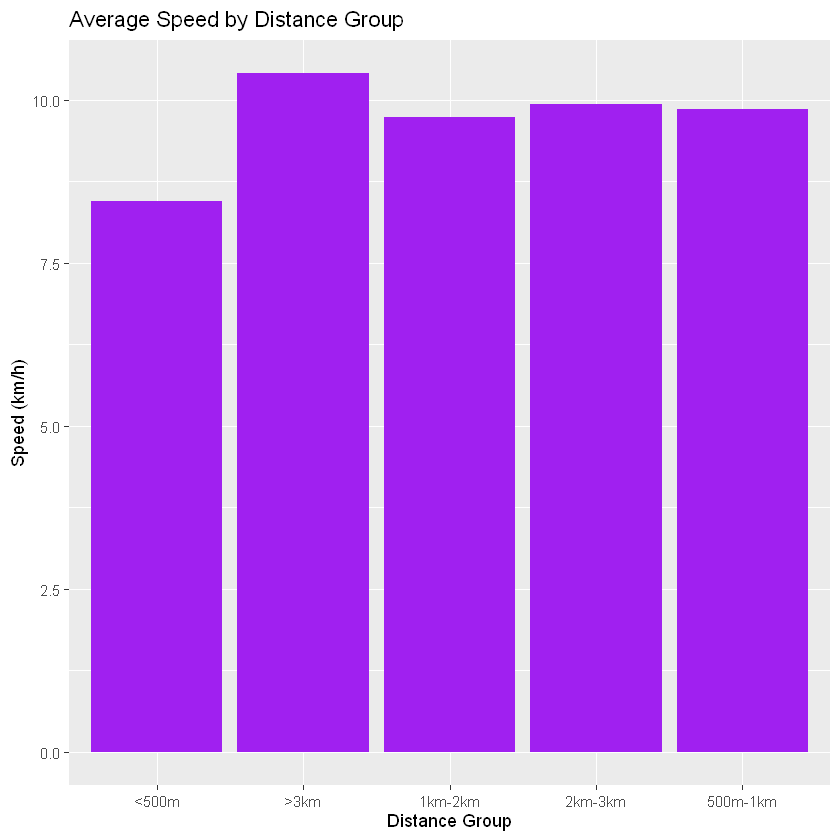

In [69]:
# 3. Create bike_speed 
bike_speed <- bike_skimmed %>% 
  filter(duration_min <= 60) %>%  # Trips ≤1 hour
  mutate(
    distance = distHaversine(
      cbind(`start station longitude`, `start station latitude`),
      cbind(`end station longitude`, `end station latitude`)
    ) / 1000,  # Convert to km
    speed = distance / (tripduration / 3600)
  ) %>% 
  filter(distance > 0)  # Remove zero-distance trips


bike_speed %>% 
  mutate(
    distance_group = case_when(
      distance < 0.5 ~ "<500m",
      distance < 1 ~ "500m-1km",
      distance < 2 ~ "1km-2km",
      distance < 3 ~ "2km-3km",
      TRUE ~ ">3km"
    )
  ) %>% 
  group_by(distance_group) %>% 
  summarise(avg_speed = mean(speed)) %>% 
  ggplot(aes(x = distance_group, y = avg_speed)) +
  geom_col(fill = "purple") +
  labs(title = "Average Speed by Distance Group", x = "Distance Group", y = "Speed (km/h)")

In [23]:
# 8.1 Most Common Start / Least Common End
most_common_start <- bike_skimmed %>% 
  count(`start station id`, sort = TRUE) %>% 
  slice(1)

least_common_end <- bike_skimmed %>% 
  count(`end station id`, sort = TRUE) %>% 
  slice_tail(n = 1)

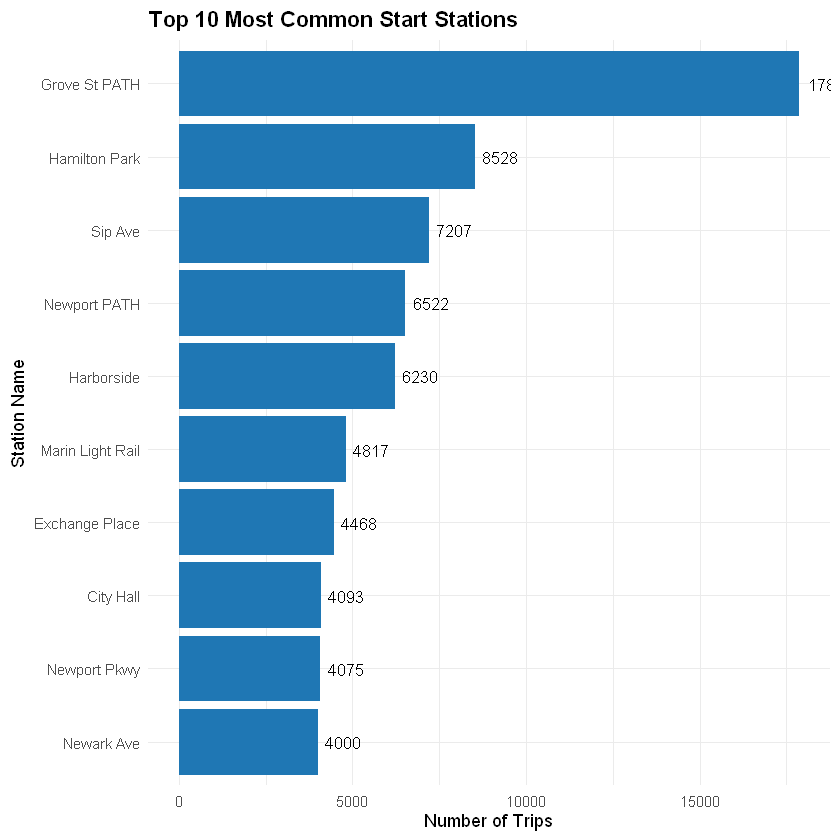

In [25]:
# Get top 10 start stations
top_start_stations <- bike_skimmed %>%
  count(`start station id`, `start station name`, sort = TRUE) %>%
  slice_head(n = 10)  # Top 10

# Plot
ggplot(top_start_stations, aes(x = reorder(`start station name`, n), y = n)) +
  geom_col(fill = "#1f77b4") +
  geom_text(aes(label = n), hjust = -0.2, size = 3.5) +  # Add counts on bars
  coord_flip() +  # Horizontal bars
  labs(
    title = "Top 10 Most Common Start Stations",
    x = "Station Name",
    y = "Number of Trips"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold"))

In [27]:
# 8.2 Most/Least Common Routes
common_routes <- bike_skimmed %>% 
  count(`start station id`, `end station id`, sort = TRUE) %>% 
  slice_head(n = 3)

least_common_routes <- bike_skimmed %>% 
  count(`start station id`, `end station id`, sort = TRUE) %>% 
  slice_tail(n = 3)

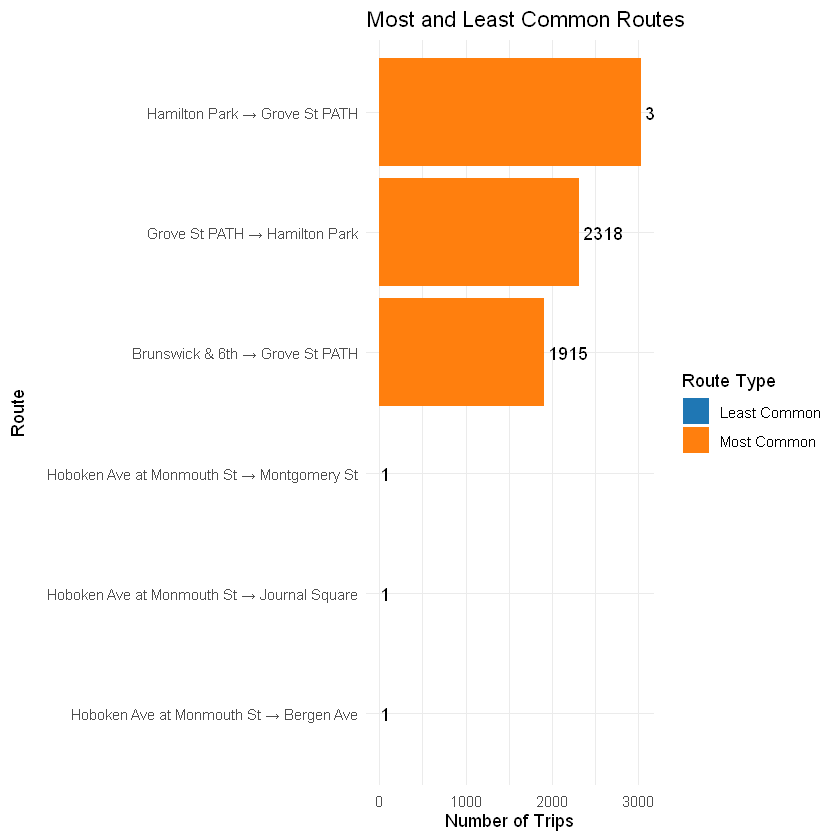

In [81]:
library(ggplot2)

# Combine most/least common routes
all_routes <- bind_rows(
  common_routes %>% mutate(type = "Most Common"),
  least_common_routes %>% mutate(type = "Least Common")
) %>%
  # Join with station names (replace with your actual data)
  left_join(bike_skimmed %>% distinct(`start station id`, `start station name`), 
            by = "start station id") %>%
  left_join(bike_skimmed %>% distinct(`end station id`, `end station name`), 
            by = "end station id") %>%
  mutate(route = paste(`start station name`, "→", `end station name`))

# Plot
ggplot(all_routes, aes(x = reorder(route, n), y = n, fill = type)) +
  geom_col() +
  geom_text(aes(label = n), hjust = -0.1) +
  coord_flip() +
  scale_fill_manual(values = c("#1f77b4", "#ff7f0e")) +
  labs(
    title = "Most and Least Common Routes",
    x = "Route",
    y = "Number of Trips",
    fill = "Route Type"
  ) +
  theme_minimal()